In [1]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.firefox import GeckoDriverManager
import spacy
import time
import os
from langdetect import detect
import nltk
import csv
import ast
import timeit
import pandas as pd
import math
import heapq
import matplotlib.pyplot as plt

In [2]:
href = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page=1"
driver = webdriver.Firefox(executable_path = GeckoDriverManager().install())

[WDM] - Getting latest mozilla release info for v0.28.0
[WDM] - Trying to download new driver from https://github.com/mozilla/geckodriver/releases/download/v0.28.0/geckodriver-v0.28.0-linux64.tar.gz
[WDM] - Driver has been saved in cache [/home/michele/.wdm/drivers/geckodriver/linux64/v0.28.0]


#### These three cells load the vocabulary and the dictionaries from text files

In [57]:
file = open("vocabulary.txt", "r")
vocabulary = next(file)
file.close()
vocabulary = ast.literal_eval(vocabulary)

In [58]:
file = open("inverted_index_dictionary.txt", "r")
inverted_index_dictionary = next(file)
file.close()
inverted_index_dictionary = ast.literal_eval(inverted_index_dictionary)

In [59]:
file = open("inverted_index_dictionary_tfidf.txt", "r")
inverted_index_dictionary_tfidf = next(file)
file.close()
inverted_index_dictionary_tfidf = ast.literal_eval(inverted_index_dictionary_tfidf)

In [60]:
file = open("dictionary_tfidf.txt", "r")
dictionary_tfidf = next(file)
file.close()
dictionary_tfidf = ast.literal_eval(dictionary_tfidf)

In [61]:
file = open("authors_dictionary.txt", "r")
authors_dictionary = next(file)
file.close()
authors_dictionary = ast.literal_eval(authors_dictionary)

In [62]:
file = open("title_dictionary.txt", "r")
titles_dictionary = next(file)
file.close()
titles_dictionary = ast.literal_eval(titles_dictionary)

## 1. Data collection

### 1.1. Get the list of books

In [130]:
def get_urls(href, driver, pages_num):
    
    href = href[0:-1]
    
    file = open("urls.txt", "w")
    
    for i in range(1, pages_num + 1):
        
        new_href = href + str(i)
        driver.get(new_href)
        page_soup = BeautifulSoup(driver.page_source, features="lxml")
        links_list = page_soup.find_all("a", {'class' : 'bookTitle'}, itemprop = "url")
        
        for link in links_list:
            url = link.get("href")
            file.write("https://www.goodreads.com" + url + "\n")
        
        print(" | "+str(i), end = "")
            
    file.close()

In [131]:
#get_urls(href, driver, 300)

### 1.2. Crawl books

In [ ]:
def download_htmls(href, driver):
    
    urls_file = open("urls.txt", "r")
    urls_count = 1
    num_page = 1
    
    for url in urls_file:
        
        if (urls_count % 100) == 0:
            num_page += 1
            os.mkdir("page" + str(num_page))
        
        driver.get(url)
        
        file = open("page"+str(num_page)+"/"+"article_"+str(urls_count+1)+".html", "w")
        file.write(driver.page_source)
        file.close()
        
        urls_count += 1
        print(" | "+str(urls_count), end = "")
            
    urls_file.close()

In [4]:
# Download 30000 html. Already done.
#download_htmls(href, driver)

### 1.3 Parse downloaded pages

In [1]:
def extract_books_informations():
    
    urls_list = list(open("urls.txt", "r"))
    from_page = 1
    to_page = 300
    bf = []
    
    for num_page in range(from_page, to_page+1):
        
        from_html = ((num_page-1) * 100) + 1
        to_html = (num_page * 100) + 1
        
        for current_html in range(from_html, to_html):
            webpage = open("page"+str(num_page)+"/article_"+str(current_html)+".html")
            soup = BeautifulSoup(webpage, features = "lxml")
            
            # Sometimes the funcition download_htmls doesn't work well and the html pages are without the fields
            # we needed (title, plot ecc), for this reason we use a "try" before taking the title, in case of
            # an error, we append the "broken file" in the bf list so that we'll be able to download it again.
            try:
                #TITLE
                bookTitle = soup.find_all("h1", id = "bookTitle")[0].contents[0].strip()
            except:
                print(" | " + str(current_html)+" Unexpected broken file")
                bf.append(current_html)
                continue
            
            #SERIES
            bookSeries = soup.find_all("h2", id = "bookSeries")[0].find_all("a")
            if bookSeries:
                bookSeries = bookSeries[0].contents[0].strip("\n ()")
                if bookSeries != "":  
                    if bookSeries[-1].isnumeric():
                        bookSeries = bookSeries.strip(" "+str(bookSeries[-1])+"#")
            else:
                bookSeries = ""
            
            #AUTHOR
            #In the <a> link there is a <span> with the author's name inside
            bookAuthors = soup.find_all("a", {'class' : 'authorName'})[0].contents[0].contents[0].strip()
            
            #RATING VALUE
            ratingValue = soup.find_all("span", itemprop = "ratingValue")[0].contents[0].strip()
            ratingValue = float(ratingValue)
            
            #RATING COUNT
            ratingCount = soup.find_all("meta", itemprop = "ratingCount")[0]["content"]
            ratingCount = int(ratingCount)
            
            #REVIEW COUNT
            reviewCount = soup.find_all("meta", itemprop = "reviewCount")[0]["content"]
            reviewCount = int(reviewCount)
            
            #PLOT
            plot = soup.find_all("div", id = "description")
            if len(plot) == 0:
                plot = ""
            else:
                plot = plot[0].find_all("span")
                if(len(plot) == 1):
                    plot = plot[0].get_text(separator = " ").strip(" \n'\"").replace("\n", "")
                else:
                    plot = plot[1].get_text(separator = " ").strip(" \n'\"").replace("\n", "")
                try:
                    if detect(plot) != "en":
                        continue
                except:
                    print("NO_PLOT\n")
                    continue
            #NUMBER OF PAGES
            numberOfPages = soup.find_all("span", itemprop = "numberOfPages")
            if(len(numberOfPages) == 0):
                numberOfPages = ""
            else:
                numberOfPages = numberOfPages[0].contents[0].strip(" pages")
                numberOfPages = int(numberOfPages)
            
            #PUBLISHING DATE
            publishingDate = soup.find_all("div", id = "details")[0].find_all("div", {"class" : "row"})
            if len(publishingDate) == 0:
                publishingDate = ""
            else:
                if len(publishingDate[0].find_all("span")) != 0:
                    if len(publishingDate) == 1:
                        publishingDate = ""
                    else:
                        publishingDate = publishingDate[1].contents[0].strip("\n ").split("\n")
                else:
                    publishingDate = publishingDate[0].contents[0].strip("\n ").split("\n")
                if len(publishingDate) <= 1:
                    publishingDate = ""
                else:
                    publishingDate = publishingDate[1].strip()

            #CHARACTERS
            all_links = soup.find_all("div", id = "bookDataBox")[0].find_all("a")
            characters = ""
            for link in all_links:
                if "/characters/" in link["href"]:
                    characters += link.contents[0].strip() + ", "
            characters = characters.strip(", ")
            
            #PLACES
            all_links = soup.find_all("div", id = "bookDataBox")[0].find_all("a")
            places = ""
            for link in all_links:
                if "/places/" in link["href"]:
                    places += link.contents[0].strip() + ", "
            places = places.strip(", ")
            
            #URL
            url = urls_list[current_html-1]
            
            #FILE tsv
            article = open("articles/article_" +str(current_html)+".tsv", "w")
            
            article.write("bookTitle\tbookSeries\tbookAuthors\tratingValue\tratingCount\treviewCount\tplot\tnumberOfPages\tpublishingDate\tcharacters\tplaces\turl\n")

            article.write(bookTitle+"\t"+bookSeries+"\t"+bookAuthors+"\t"+str(ratingValue)+"\t"+str(ratingCount)+"\t"+str(reviewCount)+"\t"+plot+"\t"+str(numberOfPages)+"\t"+publishingDate+"\t"+characters+"\t"+places+"\t"+url)
            
            article.close()
            
            webpage.close()
            
            print(" | " + str(current_html), end = "")
            
        return bf

In [26]:
#bf = extract_books_informations()

## 2. Search Engine

In [2]:
# Takes a string in input and return a new stemmed string with no punctuation and no stopwords. 
def process_plot(plot):
    
    # Removing punctuation
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(plot.lower())
    
    # Removing stopwords
    new_plot = [word for word in tokens if not word in nltk.corpus.stopwords.words("english")]
    
    # Stemming
    stemmer = nltk.stem.porter.PorterStemmer()
    singles = [stemmer.stem(word) for word in new_plot]
    
    new_plot = ' '.join(singles)
    
    return new_plot

In [6]:
# This function takes all the articles (.tsv) and transforms their plot with the process_plot function above, 
# then saves the new processed plot on a new column called "processedPlot"

def process_articles():
    
    files_number = 30000

    for i in range(1, files_number+1):
        
        
        # Some articles are missing (for example those that are not in English), in these cases we 
        # just skip them.
        try:
            file = open("articles/article_"+str(i)+".tsv", "r")
        except:
            continue

        reader = csv.reader(file, delimiter="\t")

        lines = list(reader)

        plot = lines[1][6]

        lines[0].append("processedPlot")
        lines[1].append(process_plot(plot))

        file.close()
        file = open("articles/article_"+str(i)+".tsv", "w")

        writer = csv.writer(file, delimiter="\t")
        writer.writerows(lines)

        file.close()
        
    print("Done.")

In [14]:
process_articles()

Done.


### 2.1. Conjunctive query

In [3]:
# This function takes all the words of all the articles and map each word to a number (with the use of a 
# dictionary) then save the vocabulary into a txt file.
def new_vocabulary():
    
    vocabulary = {}
    
    num_articles = 30000
    term_id = 0
    
    for doc_i in range(1, num_articles+1):
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        # converts a tsv file into a list of 2 elements. The first element is the list of columns names (useless),
        # the second element is the list of values.
        lines = list(reader)
        # lines[1][12] contains the "processed plot"
        plot = lines[1][12]
        # lines[1][0] contains the title
        title = process_plot(lines[1][0])
        # lines[1][3] contains the authors
        author = process_plot(lines[1][2])
            
        values = plot + " " + title + " " + author
        values = values.split()

        for word in values:
            if word not in vocabulary:
                vocabulary[word] = term_id
                term_id += 1
        
    file = open("vocabulary.txt", "w")
    file.write(str(vocabulary))
    file.close()

    print("Done.")

    return vocabulary

In [4]:
vocabulary = new_vocabulary()

Done.


In [5]:
# This function is used to update the dictionary (or create a new one if we do not pass an existing dictionary)
# Each key is a term_id and the values are the documents that contains the term
def update_dictionary(vocabulary, inverted_index_dictionary = {}):
    
    num_articles = 30000
    
    for doc_i in range(1, num_articles+1):
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        # get the "processed plot"
        plot = lines[1][12].split()

        for word in plot:
            term_id = vocabulary[word]
            if term_id not in inverted_index_dictionary:
                inverted_index_dictionary[term_id] = []
            if doc_i not in inverted_index_dictionary[term_id]:
                inverted_index_dictionary[term_id].append(doc_i)
    
    file = open("inverted_index_dictionary.txt", "w")
    file.write(str(inverted_index_dictionary))
    file.close()
    
    print("Done.")
    
    return inverted_index_dictionary

In [6]:
inverted_index_dictionary = update_dictionary(vocabulary)

Done.


#### In this algortithm we want to compare, for each word, the documents that contain it. To do this, we scroll in parallel the lists of documents of each word and if we find the same number in all the lists we keep this value in a new list, instead if the numbers are different we add by 1 all the indices of the documents lower than the maximum document.
#### Below we show an example of how this algorithm works.

```
word1 = [1, 2, 5, 7, 10] 
word2 = [1, 3, 5, 10, 12, 13] 
word3 = [1, 3, 4, 5, 10, 11] 
index = [0, 0, 0] 
result = [] 

word1[0] == word2[0] == word3[0]
result = [1]
index = [1, 1, 1]

word1[1] < word2[1] == word3[1]
result = [1]
index = [2, 1, 1]

word1[2] > word2[1] == word3[1]
result = [1]
index = [2, 2, 2]

word1[2] == word2[2] > word3[2]
result = [1]
index = [2, 2, 3]

word1[2] == word2[2] == word3[3]
result = [1, 5]
index = [3, 3, 4]

word1[3] < word2[3] == word3[4]
result = [1, 5]
index = [4, 3, 4]

word1[4] == word2[3] == word3[4]
result = [1, 5, 10]
index = [5, 4, 5]

word1[5] > len(word1) => STOP
```

In [204]:
# Official search, it use the algorithm explained in class and above
def search(query, vocabulary, inverted_index_dictionary):
    
    start = time.time()
    
    # If the query is empty, print that there are no results and then stop the function
    if query == "":
        res = []
        end = time.time()
        seconds = end - start
        print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
        return
    
    # Process the query removing stopwords, punctuation and by stemming
    query = process_plot(query)
    print(query)
    
    # I want only the documents that contain at least one query word
    docs_list = []
    tokens = query.split()
    for token in tokens:
        if token in vocabulary:
            token_id = vocabulary[token]
            if token_id in inverted_index_dictionary:
                docs_list.append(inverted_index_dictionary[token_id])
            else:
                docs_list.append([])
        else:
            docs_list.append([])

    res = []
    
    # Initialize a list of indices, one for each list of documents so that I can scroll them
    n = len(docs_list)
    index = [0]*n
    
    # This list is useful to know if I have checked all the elements of a list
    # in this case I have to stop the algorithm
    lists_len = [len(docs) for docs in docs_list]
    
    run = True
    
    
    # If for a given word there are no documents that contain it, then run = False, and res is an empty list
    for doc in docs_list:
        if doc == []:
            run = False
            
    while run:
        
        # Comp keeps the documents I want to compare
        comp = []
        for i in range(n):
            comp.append(docs_list[i][index[i]])
        
        
        # I compare the documents that are in comp list. If even one of them is greater than 
        # the largest document, then I can conclude that the documents are not equal and therefore 
        # I increase by 1 all the indices of the documents smaller than the maximum
        max_comp = max(comp)
        equal = True
        for j in range(len(comp)):
            if comp[j] < max_comp:
                equal = False
                index[j] += 1
                
        # If all the documents are equal it means that contain all the words, I can insert the 
        # document number in the result list
        if equal:
            res.append(comp[0])
            index = [x+1 for x in index]
        
        # Stop when a list of documents is finished
        run = True
        for k in range(len(index)):
            run = run and (index[k] < lists_len[k])
            
    end = time.time()
    
    seconds = (end - start)
    
    # Print all the books found
    print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
    l = 1
    for doc_i in res:
        article = open("articles/article_"+str(doc_i)+".tsv", "r")
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        title = lines[1][0]
        plot = lines[1][6]
        url = lines[1][11]
        print("====== " +'\033[91m' + "Book n." + str(l) +'\033[0m' + " ======\n")
        print('\033[1m' + "Title : " + '\033[0m' + title + "\n")
        print('\033[1m' + "Plot : " + '\033[0m' + plot + "\n")
        print('\033[1m' + "url :" + '\033[0m', end = " ")
        print(url + "\n")
        l += 1
        

In [205]:
query = input("Search: ")
search(query, vocabulary, inverted_index_dictionary)

Search: lord of the rings
lord ring

About 2 results (0.001 seconds)

====== Book n.1 ======

Title : J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings

Plot : This four-volume, boxed set contains J.R.R. Tolkien's epic masterworks The Hobbit and the three volumes of The Lord of the Rings (The Fellowship of the Ring, The Two Towers, and The Return of the King). In The Hobbit, Bilbo Baggins is whisked away from his comfortable, unambitious life in Hobbiton by the wizard Gandalf and a company of dwarves. He finds himself caught up in a plot to raid the treasure hoard of Smaug the Magnificent, a large and very dangerous dragon. The Lord of the Rings tells of the great quest undertaken by Frodo Baggins and the Fellowship of the Ring: Gandalf the wizard; the hobbits Merry, Pippin, and Sam; Gimli the dwarf; Legolas the elf; Boromir of Gondor; and a tall, mysterious stranger called Strider. J.R.R. Tolkien's three volume masterpiece is at once a classic myth and a modern fai

### 2.2 Conjunctive query & Ranking score

In [7]:
# It just calculates the tfidf value. tf = word frequence into a document, n = number of total documents,
# N_j = number of documents containing the word
def tfidf(tf, N_j, n):
    return round(tf*math.log(n/N_j), 11)

In [63]:
# In this dictionary [inverted_index_dictionary_tfidf] we save, in addition to the documents numbers, 
# also the tfidf value corresponding to each document-word pair.
# We also create a second dictionary [dictionary_tfidf] that has the documents number as key and the pair 
# (word, tfidf) as values.

def update_dictionary_tfidf(old_dictionary, inverted_index_dictionary_tfidf = {}, dictionary_tfidf = {}):
    
    num_articles = 30000
    
    for doc_i in range(1, num_articles+1):
        
        words_counter = {}
        
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        plot = lines[1][12].split()
        
        for word in plot:
            term_id = vocabulary[word]
            if term_id not in words_counter:
                words_counter[term_id] = 1
            else:
                words_counter[term_id] += 1
        
        for word in plot:
            term_id = vocabulary[word]
            if term_id not in inverted_index_dictionary_tfidf:
                inverted_index_dictionary_tfidf[term_id] = []
                
            if doc_i not in dictionary_tfidf:
                dictionary_tfidf[doc_i] = []
            
            N_j = len(old_dictionary[term_id])
            score = tfidf(words_counter[term_id], N_j, num_articles)
            
            if [doc_i, score] not in inverted_index_dictionary_tfidf[term_id]:
                inverted_index_dictionary_tfidf[term_id].append([doc_i, score])
                
            if [term_id, score] not in dictionary_tfidf[doc_i]:
                dictionary_tfidf[doc_i].append([term_id, score])
                
    file = open("inverted_index_dictionary_tfidf.txt", "w")
    file.write(str(inverted_index_dictionary_tfidf))
    file.close()
    
    file = open("dictionary_tfidf.txt", "w")
    file.write(str(dictionary_tfidf))
    file.close()
    
    print("Done.")
    return inverted_index_dictionary_tfidf, dictionary_tfidf
    

In [9]:
inverted_index_dictionary_tfidf, dictionary_tfidf = update_dictionary_tfidf(inverted_index_dictionary)

Done.


In [10]:
def cosine_similarity(doc_i, query, dictionary_tfidf):
    
    query = set(nltk.word_tokenize(query))
    
    q = []
    d_num = []
    d_den = [elem[1] for elem in dictionary_tfidf[doc_i[0]]]
    
    i = 1
    
    for word in query:
        q.append(1)
        d_num.append(doc_i[i])
        i = i+1
        
    c = 0
    
    # cosine formula  
    for i in range(len(query)): 
        c += q[i]*d_num[i] 
        
    q = [val**2 for val in q]
    d_den = [val**2 for val in d_den]
    
    cosine = c / (sum(q)*sum(d_den))**0.5
    
    return cosine

In [11]:
# This function get in input a query, the vocabulary and the dictionary and return the list of documents that
# contains all the words in the query and the tfidf value of each word.
def aux(query, vocabulary, inverted_index_dictionary_tfidf):
    
    # I want only the documents that contain at least one query word
    docs_list = []
    tokens = query.split()
    for token in tokens:
        if token in vocabulary:
            term_id = vocabulary[token]
            if term_id in inverted_index_dictionary_tfidf:
                docs_list.append(inverted_index_dictionary_tfidf[term_id])
            else:
                docs_list.append([])
        else:
            docs_list.append([])

    res = []
    
    # Initialize a list of indices, one for each list of documents so that I can scroll them
    n = len(docs_list)
    index = [0]*n
    
    # This list is useful to know if I have checked all the elements of a list
    # in this case I have to stop the algorithm
    lists_len = [len(docs) for docs in docs_list]
    
    run = True
    
    
    # If for a given word there are no documents that contain it, then run = False, and res is an empty list
    for doc in docs_list:
        if doc == []:
            run = False
            
    while run:
        
        # Comp keeps the documents I want to compare, comp2 keeps, in addition to the documents number, 
        # also the tfidf value
        comp = []
        comp2 = []
        for i in range(n):
            comp.append(docs_list[i][index[i]][0])
            comp2.append(docs_list[i][index[i]].copy())
        
        
        # I compare the documents that are in comp list. If even one of them is greater than 
        # the largest document, then I can conclude that the documents are not equal and therefore 
        # I increase by 1 all the indices of the documents smaller than the maximum
        max_comp = max(comp)
        equal = True
        for j in range(len(comp)):
            if comp[j] < max_comp:
                equal = False
                index[j] += 1
                
        # If all the documents are equal it means that each contain all the words, in this case I don't want only
        # the document number but i want also the tfidf values, i can take them from comp2 list. The final 
        # result is a list of this type: 
        # res = [[doc_i, tfidf_w1_i, tfidf_w2_i, ..., tfidf_wm_i], ...,  [doc_j, tfidf_w1_j, tfidf_w2_j, ..., tfidf_wm_j]. 
        if equal:
            [comp2[0].append(comp2[x][1]) for x in range(1, len(comp2))]
            res.append(comp2[0])
            
            index = [x+1 for x in index]
        
        # Stop when one of the document lists is finished
        run = True
        for k in range(len(index)):
            run = run and (index[k] < lists_len[k])
            
    return res
        

In [12]:
def search_score(query, vocabulary, inverted_index_dictionary_tfidf, dictionary_tfidf, k = 100):
    
    start = time.time()
    
    if query == "":
        res = []
        end = time.time()
        seconds = end - start
        print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
        return
    
    # Process the query removing stopwords, punctuation and by stemming
    query = process_plot(query)
    
    res = aux(query, vocabulary, inverted_index_dictionary_tfidf)
    
    # I use an heap to keep in order the documents by their score
    heap = []
    heapq.heapify(heap)
    
    for doc_i in res:
        cosine = cosine_similarity(doc_i, query, dictionary_tfidf)
        
        #This is only useful for taking the elements with the same similarity in ascending order
        doc_i[0] = -doc_i[0]
        
        #Inserts in the head of the list the cosine similarity 
        doc_i.insert(0, cosine)
        heapq.heappush(heap, doc_i)
    
    end = time.time()
    seconds = (end - start)
    
    
    # Print all the books found
    print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
    
    if k < len(heap):
        # get the firsts k largest element from the heap
        res = heapq.nlargest(k, heap)
    else:
        res = heapq.nlargest(len(heap), heap)
        
    book_num = 1
    for doc_i in res:
        article = open("articles/article_"+str(-doc_i[1])+".tsv", "r")
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        title = lines[1][0]
        plot = lines[1][6]
        url = lines[1][11]
        print("====== " +'\033[91m' + "Book n." + str(book_num) +'\033[0m' + " ======\n")
        print('\033[1m' + "Title : " + '\033[0m' + title + "\n")
        print('\033[1m' + "Plot : " + '\033[0m' + plot + "\n")
        print('\033[1m' + "url :" + '\033[0m', end = " ")
        print(url + "\n")
        print('\033[1m' + "Similarity : " + '\033[0m' + str(doc_i[0]) + "\n")
        book_num += 1


In [115]:
query = input("Search : ")
try:
    k = int(input("Number of results : "))
except:
    k = 100
if k < 0:
    k = -k
search_score(query, vocabulary, inverted_index_dictionary_tfidf, dictionary_tfidf, k)

Search : survival games
Number of results : 100

About 122 results (0.042 seconds)

====== Book n.1 ======

Title : The Warden

Plot : Alice has led a normal life up until now. She wakes up finding herself trapped in a sick game of survival within the walls of an old asylum. She has to fight her way out while facing psychotic enemies, no one said they were all living psychopaths though...    When she discovers how she got there she is forced to make difficult decisions.    Will Alice survive the horror games?

url : https://www.goodreads.com/book/show/33655366-the-warden

Similarity : 0.3628728457860691

====== Book n.2 ======

Title : Devil's Own

Plot : After surviving slavery, Aiden MacAlpin has nothing but thoughts of vengeance. When his tutor Elspeth learns a secret to his past, it thrusts them both into a game of passion and deception that neither may survive.

url : https://www.goodreads.com/book/show/8705483-devil-s-own

Similarity : 0.2855417096416167

====== Book n.3 ======



### 3. Define a new score!

In [13]:
# For this exercise it is also useful to have a dictionary for titles, each key is a word and the 
# values are the documents that contain that word in the title
def update_titles_dictionary(vocabulary, dictionary = {}):
    
    num_articles = 30000
    
    for doc_i in range(1, num_articles+1):
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        # get the "processed title"
        title = process_plot(lines[1][0]).split()

        for word in title:
            term_id = vocabulary[word]
            if term_id not in dictionary:
                dictionary[term_id] = []
            if doc_i not in dictionary[term_id]:
                dictionary[term_id].append(doc_i)
    
    file = open("title_dictionary.txt", "w")
    file.write(str(dictionary))
    file.close()
    
    print("Done.")
    
    return dictionary

In [14]:
titles_dictionary = update_titles_dictionary(vocabulary)

Done.


In [68]:
# For this exercise it is also useful to have a dictionary for authors, each key is a word and the 
# values are the documents that contain that word in the authors list
def update_authors_dictionary(vocabulary, dictionary = {}):
    
    num_articles = 30000
    
    for doc_i in range(1, num_articles+1):
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        # get the "processed author's name"
        author = process_plot(lines[1][2]).split()

        for word in author:
            term_id = vocabulary[word]
            if term_id not in dictionary:
                dictionary[term_id] = []
            if doc_i not in dictionary[term_id]:
                dictionary[term_id].append(doc_i)
    
    file = open("authors_dictionary.txt", "w")
    file.write(str(dictionary))
    file.close()
    
    print("Done.")
    
    return dictionary

In [16]:
authors_dictionary = update_authors_dictionary(vocabulary)

Done.


#### To evaluate the title similarity we use this particular function. 
$y = \frac{1}{2}+\frac{\log\left(x+1\right)}{2\cdot\log\left(n+1\right)}$
####  $n =$ total number of words in the title, $x =$ number of matches between title and query, $y =$ similarity 
#### As we can see from the plot below, when the number of matches is equal to n, then y = 1. In any case the similarity is > 0.5, this because even if the number of matches is small and n is large the similarity shouldn't be too small.
#### The same formula is used to evaluate the author similarity

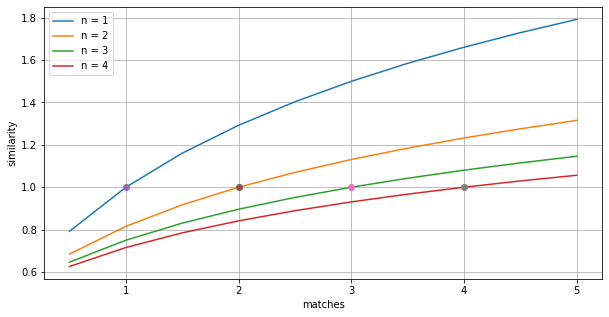

In [95]:
plt.figure(figsize=(10, 5))

n = 1
x = [x/2 for x in range(1, 11)]
y = [0.5 + math.log((x+1)**(1/(math.log(n+1)*2))) for x in x]
plt.grid()
plt.xlabel("matches")
plt.ylabel("similarity")
plt.plot(x, y, label="n = 1")

n = 2
x = [x/2 for x in range(1, 11)]
y = [0.5 + math.log((x+1)**(1/(math.log(n+1)*2))) for x in x]
plt.xlabel("matches")
plt.ylabel("similarity")
plt.plot(x, y, label="n = 2")

n = 3
x = [x/2 for x in range(1, 11)]
y = [0.5 + math.log((x+1)**(1/(math.log(n+1)*2))) for x in x]
plt.plot(x, y, label="n = 3")

n = 4
x = [x/2 for x in range(1, 11)]
y = [0.5 + math.log((x+1)**(1/(math.log(n+1)*2))) for x in x]
plt.plot(x, y, label="n = 4")

plt.plot(1, 1, marker='o')
plt.plot(2, 1, marker='o')
plt.plot(3, 1, marker='o')
plt.plot(4, 1, marker='o')

plt.legend()

In [96]:
# Now we can use the frmula above to evaluate the title and the series togheter
def evaluate_title(doc_i, query):
    
    query = query.split()
    
    article = open("articles/article_"+str(doc_i)+".tsv", "r")
    reader = csv.reader(article, delimiter="\t")
    lines = list(reader)
    title = lines[1][0]
    title = process_plot(title)
    title = title.split()
    series = lines[1][1].strip(" ()")
    series = process_plot(series)
    series = series.split()
    for elem in series:
        title.append(elem)
        
    n = len(title)
    
    score = 0
    
    for word in query:
        if word in title:
            score += title.count(word)
    
    if score != 0:
        title_score = 0.5 + math.log((score+1)**(1/(math.log(n+1)*2)))
    else:
        return 0
    
    return title_score
    

#### We use this function to evaluate the reviews number "weight": $y = 100^{-\frac{4000}{x}}$
#### If the number of reviews is small the similarity increase very slowly, instead in a certain range it increase fast, when it becomes a large enough number, it will begin to increase slowly again. The number 4000 on the numerator is not random but is choosen in such a way that the function calculated in the average of the number reviews is equal to about 0.5

#### The same formula is used to evaluate the ranking number

Text(0, 0.5, 'similarity')

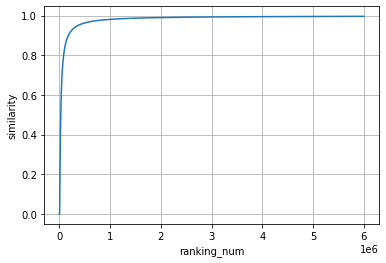

In [105]:
x = [x for x in range(1, 6000000, 1000)]
y = [100**(-(4000/x)) for x in x]
plt.plot(x, y)
plt.grid()
plt.xlabel("ranking_num")
plt.ylabel("similarity")

In [18]:
def evaluate_ranking(doc_i):
    
    article = open("articles/article_"+str(doc_i)+".tsv", "r")
    reader = csv.reader(article, delimiter="\t")
    lines = list(reader)
    ranking = float(lines[1][3])
    ranking_num = int(lines[1][4])
    reviews_num = int(lines[1][5])
    
    score1 = ranking/5
    
    if ranking_num != 0:
        score2 = 100**(-(4000/ranking_num))
    else:
        score2 = 0
        
    if reviews_num != 0:
        score3 = 100**(-(1200/reviews_num))
    else:
        score3 = 0
    
    return score1*0.2 + score2*0.4 + score3*0.4

In [19]:
def evaluate_author(doc_i, query):
    
    query = query.split()
    
    article = open("articles/article_"+str(doc_i)+".tsv", "r")
    reader = csv.reader(article, delimiter="\t")
    lines = list(reader)
    author = lines[1][2]
    author = process_plot(author)
    author = author.split()
        
    n = len(author)
    
    score = 0
    
    for word in query:
        if word in author:
            score += author.count(word)
    
    if score != 0:
        author_score = 0.5 + math.log((score+1)**(1/(math.log(n+1)*2)))
    else:
        return 0
    
    return author_score

In [106]:
def get_documents_with_element(query, vocabulary, dictionary):
    
    # I want only the documents that contain at least one query word
    docs_list = []
    tokens = query.split()
    for token in tokens:
        if token in vocabulary:
            term_id = vocabulary[token]
            if term_id in dictionary:
                docs_list.append(dictionary[term_id])
            else:
                docs_list.append([])
        else:
            docs_list.append([])
    
    docs_set = set()
    
    for doc in docs_list:
        if doc == []:
            return set()
        docs_set = docs_set.union(doc)
        
    return docs_set

In [107]:
def advanced_search(query, vocabulary, inverted_index_dictionary_tfidf, dictionary_tfidf, titles_dictionary, authors_dictionary, k = 100):
    
    start = time.time()
    
    if query == "":
        res = []
        end = time.time()
        seconds = end - start
        print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
        return
    
    query = process_plot(query)
    
    # Takes all the documents in which the plot contains the searched words
    res = aux(query, vocabulary, inverted_index_dictionary_tfidf)
    # Takes all the documents in which the title or the series contains the searched words
    res2 = get_documents_with_element(query, vocabulary, titles_dictionary)
    # Takes all the documents in which the authors names list contains the searched words
    res3 = get_documents_with_element(query, vocabulary, authors_dictionary)
    
    heap = []
    heapq.heapify(heap)
    
    # Evaluates the documents in res and if the are also in res2 or res3 takes them off to avoid repetition
    for doc_i in res:
        res2.discard(doc_i[0])
        res3.discard(doc_i[0])
        
        plot_score = cosine_similarity(doc_i, query, dictionary_tfidf)
        title_score = evaluate_title(doc_i[0], query)
        author_score = evaluate_author(doc_i[0], query)
        ranking_score = evaluate_ranking(doc_i[0])
        
        score = plot_score*0.05 + title_score*0.55 + author_score * 0.2 + ranking_score*0.2
        
        doc_i[0] = -doc_i[0]
        doc_i.insert(0, score)
        heapq.heappush(heap, doc_i)
    
    # Same with res2 and res3
    res2 = list(res2)
        
    for doc_i in res2:
        res3.discard(doc_i)
        
        plot_score = 0
        title_score = evaluate_title(doc_i, query)
        author_score = evaluate_author(doc_i, query)
        ranking_score = evaluate_ranking(doc_i)
        
        score = plot_score*0.05 + title_score*0.55 + author_score * 0.2 + ranking_score*0.2  
        
        doc_i = -doc_i
        new_doc_i = []
        new_doc_i.append(doc_i)
        new_doc_i.insert(0, score)
        heapq.heappush(heap, new_doc_i)
        
    res3 = list(res3)
        
    for doc_i in res3:        
        plot_score = 0
        title_score = 0
        author_score = evaluate_author(doc_i, query)
        ranking_score = evaluate_ranking(doc_i)
        
        score = plot_score*0.05 + title_score*0.55 + author_score * 0.2 + ranking_score*0.2
        
        doc_i = -doc_i
        new_doc_i = []
        new_doc_i.append(doc_i)
        new_doc_i.insert(0, score)
        heapq.heappush(heap, new_doc_i)
    
    end = time.time()
    seconds = (end - start)
    
    
    # Print all the books found
    print('\n\033[30m' + "About " + str(len(res)+len(res2)+len(res3)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
    
    if k < len(heap):
        res = heapq.nlargest(k, heap)
    else:
        res = heapq.nlargest(len(heap), heap)
        
    book_num = 1
    for doc_i in res:
        article = open("articles/article_"+str(-doc_i[1])+".tsv", "r")
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        title = lines[1][0]
        plot = lines[1][6]
        url = lines[1][11]
        author = lines[1][2]
        print("====== " +'\033[91m' + "Book n." + str(book_num) +'\033[0m' + " ======\n")
        print('\033[1m' + "Title : " + '\033[0m' + title + "\n")
        print('\033[1m' + "Author : " + '\033[0m' + author + "\n")
        print('\033[1m' + "Plot : " + '\033[0m' + plot + "\n")
        print('\033[1m' + "url :" + '\033[0m', end = " ")
        print(url + "\n")
        print('\033[1m' + "Similarity : " + '\033[0m' + str(doc_i[0]) + "\n")
        book_num += 1

In [ ]:
query = input("Search (title or author) : ")
try:
    k = int(input("Number of results : "))
except:
    k = 100
if k < 0:
    k = -k
advanced_search(query, vocabulary, inverted_index_dictionary_tfidf, dictionary_tfidf, titles_dictionary, authors_dictionary, k)

## 5. Algorithmic Question

In [108]:
ordered='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
dic_ord={}
for i in range(len(ordered)):
    dic_ord[i]=ordered[i]
# First we change all the alphabets to numbers by defining a dictionary so we have an easier job 
# calculating and comparing the orders.
def get_key(val): 
    for key, value in dic_ord.items(): 
         if val == value: 
                return key
    return "key doesn't exist"
# We have also defined a function to get the keys for our dictionary.    
def str_to_num(string):
    num_str=[]
    for i in range(len(string)):
        num_str.append(get_key(string[i]))
    return num_str
# Here we write function to get the numeric values of every string that we decide to work on.

In [109]:
global maximum 
def _lis(arr , n ):
    global maximum
    if n == 1 : 
        return 1
    maxEndingHere = 1
    for i in range(1, n): 
        res = _lis(arr , i) 
        if arr[i-1] < arr[n-1] and res+1 > maxEndingHere: 
            maxEndingHere = res +1
    maximum = max(maximum , maxEndingHere) 
    return maxEndingHere 
def lis(arr):  
    global maximum 
    n = len(arr) 
    maximum = 1
    _lis(arr , n) 
    return maximum
# first we wrote the code for the recursive function and as written in the assignment it works but the 
# running time is exponential so for the long strings it will have an enormous running time.

In [110]:
string='CADFECEILGJHABNOPSTIRYOEA'
num_str=str_to_num(string)
print(lis(num_str))
string='JHFEJHBEFL'
num_str=str_to_num(string)
print(lis(num_str))
string='ABCDEFG'
num_str=str_to_num(string)
print(list(num_str))
# In this cell we examined the funjction with some different strings and we see that specially for the 
# first string the running time is noticable

11
4
[0, 1, 2, 3, 4, 5, 6]


In [111]:
import random
import time
my_list=[random.randint(0,25)]
running_time=[]
for i in range(0,25):    
    start_time = time.time()
    lis(my_list)
    running_time.append(time.time() - start_time)
    my_list.append(random.randint(0,25))
print(my_list,running_time)

# In this cell we want to show that the running time is exponential so we made a for loop whch within it
# we add a member to our list from 0 to 25 (like a string simulation) and we see how much time it takes for
# each loop. Then we save them all in the list running_time.

[4, 9, 19, 20, 3, 15, 18, 23, 9, 12, 13, 10, 21, 11, 0, 10, 9, 9, 17, 4, 2, 3, 13, 20, 4, 23] [6.4373016357421875e-06, 1.1682510375976562e-05, 1.1444091796875e-05, 1.7404556274414062e-05, 2.86102294921875e-05, 5.1975250244140625e-05, 9.846687316894531e-05, 0.00019407272338867188, 0.00038552284240722656, 0.0007643699645996094, 0.0018055438995361328, 0.0030670166015625, 0.004431247711181641, 0.00635981559753418, 0.008960247039794922, 0.012713909149169922, 0.020204782485961914, 0.04187273979187012, 0.07862544059753418, 0.15384364128112793, 0.3117361068725586, 0.6295840740203857, 1.2925679683685303, 2.575147867202759, 5.108435392379761]


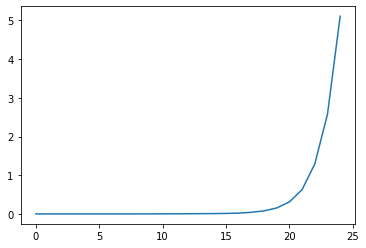

In [112]:
import matplotlib.pyplot as plt
plt.plot(running_time)
# As we can see in the plot the running time is exponental and it is 2^n 

In [113]:
def lis_dp(arr):
    a=np.ones(len(arr),int)
    for i in range(1,len(arr)):
        for j in range(i):
            if arr[i]> arr[j]:
                a[i]=max((a[j]+1),a[i])
    return max(a)
# This is the function we made using dynamic programming it gives us the same results and the running
# time is much more efficient (n^2)